# Install Google Dependencies

In [0]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1F1mpgaojcCAi-_5OIoHItUt-3BeTT6a9'})
download.GetContentFile('data.zip')
!unzip data.zip

Archive:  data.zip
  inflating: data/Data Dictionary.xlsx  
  inflating: data/Data Dictionary(1).xlsx  
  inflating: data/VALIDATION_SET.csv  
  inflating: data/1. DEMO_BANK_INFO.csv  
  inflating: data/SUBMISSION.csv     
  inflating: data/5. RAW_TELCO_TRANSACTIONS.csv  
  inflating: data/3. AGGREGATED_TELCO_TRANSACTIONS.csv  
  inflating: data/4. MOBILE_OS.csv   
  inflating: data/2. BANK_TELCO_ID_MATCH.csv  


# Main Code

In [0]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import cross_validate

from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn import svm

## Data Preparation

### Get Directory

In [0]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
os.listdir(DATA_PATH)

['4. MOBILE_OS.csv',
 '5. RAW_TELCO_TRANSACTIONS.csv',
 'VALIDATION_SET.csv',
 'Data Dictionary.xlsx',
 '2. BANK_TELCO_ID_MATCH.csv',
 '1. DEMO_BANK_INFO.csv',
 'Data Dictionary(1).xlsx',
 '3. AGGREGATED_TELCO_TRANSACTIONS.csv',
 'SUBMISSION.csv']

### Load DEMO_BANK_INFO.csv

In [0]:
demo_bank_df = pd.read_csv(os.path.join(DATA_PATH, '1. DEMO_BANK_INFO.csv'))
demo_bank_df.head()

,BANK_ID,AGE,MARITAL_STATUS,POSTAL_CD,GENDER,EDUCATION,STATE,OCCUPATION,OCC_DESC,CUST_SEGMENT,...,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,INS_LIFE_CNT,INS_NON_LIFE_CNT,INS_CNT,loan_application_date,DELQ_FLG
0,13398,42,Single,48020.0,Male,No Formal Education / Unknown,Selangor Darul Ehsan,"Associate Professionals, Administrative/Specia...",MANAGER OR SUPERVISOR,MASS,...,2,0,0,0,0,0,0,0,31-Dec-17,N
1,16152,37,Married,73430.0,Male,No Formal Education / Unknown,Negeri Sembilan Darul Khusus,Associate Professionals/Technician/Asst/Superv...,OTHERS,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N
2,18560,34,Single,70450.0,Male,No Formal Education / Unknown,Negeri Sembilan Darul Khusus,"Clerical Support Workers, Office - General Off...",NON-EXECUTIVE,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N
3,18568,34,Married,47130.0,Male,College/ University,Selangor Darul Ehsan,Associate Professionals/Technician/Asst/Superv...,EXECUTIVE AND ABOVE,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N
4,26717,26,Single,5150.0,Female,NaN,Kedah Darul Aman,"Professionals, Administration/Policy Analyst/M...",EXECUTIVE AND ABOVE,MASS,...,0,0,0,0,0,0,0,0,31-Dec-17,N


### Load Validation Data

In [0]:
validation_df = pd.read_csv(os.path.join(DATA_PATH, 'VALIDATION_SET.csv'))
validation_df.head()

,BANK_ID,AGE,MARITAL_STATUS,POSTAL_CD,GENDER,EDUCATION,STATE,OCCUPATION,OCC_DESC,CUST_SEGMENT,...,SA_CNT,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,INS_LIFE_CNT,INS_NON_LIFE_CNT,INS_CNT,loan_application_date
0,10001,59,Married,47500.0,Male,Bachelor,Selangor Darul Ehsan,"Professionals, Passenger/Cargo Aircraft - Air ...",OTHERS,PREFERRED,...,1.0,1,0,0,0,0,0,0,0,4-Jul-17
1,10006,58,Married,75200.0,Male,Secondary,Melaka,"Plant/Machine, Drivers/Mobile Plant Operators...",NON-EXECUTIVE,MASS,...,1.0,0,0,0,0,0,0,0,0,1-Nov-17
2,10018,58,Married,40400.0,Male,Secondary,Selangor Darul Ehsan,"Plant/Machine, Drivers/Mobile Plant Operators...",NON-EXECUTIVE,MASS,...,1.0,0,1,0,0,0,0,0,0,5-Jul-17
3,10019,58,Married,81700.0,Male,No Formal Education / Unknown,Johor Darul Takzim,"Associate Professionals, Artistic and Cultural...",OTHERS,MASS,...,1.0,0,0,0,0,0,0,0,0,29-Dec-17
4,10028,57,Married,48050.0,Male,NaN,Selangor Darul Ehsan,"Managers, Administrative/Commercial Managers/A...",MANAGER OR SUPERVISOR,PREFERRED,...,1.0,1,1,0,0,0,0,0,0,10-Aug-17


### Data pre-processing on customer's bank information

In [0]:
def preprocessing_1(datapath, dataframe, train=True, save=False):
    '''
    Function that does the preprocessing according to #1 refer to readme
    '''
    dataframe.drop(columns=['POSTAL_CD', 'OCCUPATION',
                            'INS_CNT', 'CA_AVG_BAL', 'INS_NON_LIFE_CNT'], inplace=True)
    dataframe.update(dataframe[['SA_AVG_BAL', 'CA_CNT', 'SA_CNT']].fillna(0))
    dataframe.update(dataframe['EDUCATION'].fillna('No Formal Education / Unknown'))
    if train:
        dataframe['DELQ_FLG'] = np.where(dataframe['DELQ_FLG']=='Y', 1, 0)
    
    # Age
    dataframe['AGE'] = pd.cut(
        dataframe.AGE, [21, 28, 32, 39, 59], include_lowest=True, labels=[0, 1, 2, 3])

    # Marital Status
    dataframe['MARITAL_STATUS'][(dataframe['MARITAL_STATUS'] == 'Not Applicable / Blank') | (
        dataframe['MARITAL_STATUS'] == 'Divorced') | (dataframe['MARITAL_STATUS'] == 'Widow') |
        (dataframe['MARITAL_STATUS'] == 'Widow')] = 'Others'
    
#     dataframe['MARITAL_STATUS'][dataframe['MARITAL_STATUS'].isin(['Separated'])] = 'Others'

    # State
    dataframe['STATE'][dataframe['STATE'].isin(
        ['WP - Kuala Lumpur', 'STATE_INFO_NOT_PROVIDED'])] = 'HH'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['WP - Labuan', 'Pulau Pinang', 'Sarawak', 'Selangor Darul Ehsan', 'WP - Putrajaya','Melaka'])] = 'H'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['Negeri Sembilan Darul Khusus', 'Pahang Darul Makmur', 'Johor Darul Takzim', 'Terengganu Darul Iman', 'Perak Darul Ridzuan'])] = 'M'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['Sabah', 'Perlis Indra Kayangan', 'Kedah Darul Aman'])] = 'L'
    dataframe['STATE'][dataframe['STATE'].isin(
        ['Kelantan Darul Naim'])] = 'LL'

    # Education
    dataframe['EDUCATION'][dataframe['EDUCATION'].isin(
        ['Primary', 'Secondary', 'No Formal Education / Unknown'])] = 'LE'
    dataframe['EDUCATION'][~dataframe['EDUCATION'].isin(['LE'])] = 'HE'

    # OCC DESC
    dataframe['OCC_DESC'][dataframe['OCC_DESC'].isin(
        ['MANAGER OR SUPERVISOR', 'EXECUTIVE AND ABOVE'])] = 'EXEC2MANAGER'
    dataframe['OCC_DESC'][dataframe['OCC_DESC'].isin(
        ['HOUSEWIFE', 'SELF EMPLOYED', 'STUDENT', 'RETIRED'])] = 'OTHERS'

    # Salary Avg Bal
    temp_df1 = pd.read_csv(os.path.join(os.path.join(DATA_PATH, '1. DEMO_BANK_INFO.csv')))
    scaler = preprocessing.MinMaxScaler()
#     scaler.fit_transform(temp_df1['SA_AVG_BAL'])
    dataframe['SA_AVG_BAL'] = pd.DataFrame(scaler.fit_transform(dataframe[['SA_AVG_BAL']]))

    # loan application dates
    dataframe['loan_application_date_DOW'] = pd.DatetimeIndex(
        dataframe['loan_application_date']).dayofweek
    dataframe['loan_application_date_month'] = pd.DatetimeIndex(
        dataframe['loan_application_date']).month
    dataframe['loan_application_date_week'] = pd.DatetimeIndex(
        dataframe['loan_application_date']).week
    dataframe.drop(columns=['loan_application_date'], inplace=True)

    # One Hot encoding
    dataframe = pd.get_dummies(dataframe, columns=['AGE', 'MARITAL_STATUS', 'GENDER', 'EDUCATION', 'STATE', 'OCC_DESC',
                                                   'CUST_SEGMENT', 'loan_application_date_DOW', 'loan_application_date_month', 'loan_application_date_week'])

    if save:
        SAVE_PATH = os.path.join(os.getcwd(), '..', 'data')
        dataframe.to_csv(os.path.join(SAVE_PATH, 'preprocessed_1.csv'))
    return dataframe


### Data pre-processing on Telco data

In [0]:
def preprocessing_2(datapath, save=False):
    '''
    Function that does the preprocessing according to #2 refer to readme
    '''
    temp_df1 = pd.read_csv(os.path.join(datapath, '2. BANK_TELCO_ID_MATCH.csv'))
    temp_df2 = pd.read_csv(os.path.join(datapath, '3. AGGREGATED_TELCO_TRANSACTIONS.csv'))
    temp_df3 = pd.read_csv(os.path.join(datapath, '4. MOBILE_OS.csv'))


    # Avg postpaid and prepaid amt
    scaler = preprocessing.MinMaxScaler()
    temp_df2['AVG_POSTPAID_AMT'] = pd.DataFrame(scaler.fit_transform(temp_df2[['AVG_POSTPAID_AMT']]))
    temp_df2['AVG_PREPAID_AMT'] = pd.DataFrame(scaler.fit_transform(temp_df2[['AVG_PREPAID_AMT']]))
    temp_df2 = temp_df2.filter(['TELCO_ID', 'AVG_POSTPAID_AMT', 'AVG_POSTPAID_CNT', 'AVG_PREPAID_AMT', 'AVG_PREPAID_CNT'])


    # OS
    android = ['samsung', 'OPPO', 'HUAWEI', 'SONY', 'XIAOMI', 'LENOVO', 'ASUS', 'VIVO', 'ANDROID', 'Android_OS8', 'Android_OS7', 'Android_OS6', 'Android_OS5', 'Android_OS4_1']
    ios = ['IPAD_TAG', 'IPHONE_TAG', 'IPHONE_IOS8', 'IPHONE_IOS9', 'IPHONE_IOS10', 'IPHONE_IOS11']

    temp_df3['Android'] = temp_df3.loc[:, android].sum(axis=1)
    temp_df3['IOS'] = temp_df3.loc[:, ios].sum(axis=1)

    temp_df3['Android'][temp_df3['Android'] > 0] = 1
    temp_df3['IOS'][temp_df3['IOS'] > 0] = 1

    temp_df3 = temp_df3.filter(['BANK_ID', 'Android', 'IOS'])


    # Clean telco data
    cleaned_telco_df = temp_df1.merge(temp_df2, on='TELCO_ID', how='left').merge(temp_df3, on='BANK_ID', how='left')
    cleaned_telco_df.update(cleaned_telco_df[['AVG_POSTPAID_AMT', 'AVG_POSTPAID_CNT', 'AVG_PREPAID_AMT', 'AVG_PREPAID_CNT']].fillna(0))
    
    return cleaned_telco_df

In [0]:
def preprocessing_3(cleaned_bank_df, cleaned_telco_df, save=False):
    '''
    Function that does the preprocessing according to #3 refer to readme

    Requires preprocessing step 2 to be ran first
    Arguments:
    -----------
    cleaned_bank_df
    cleaned_telco_df

    Returns:
    --------
    final_df
    '''
    full_df = cleaned_bank_df.merge(cleaned_telco_df, on='BANK_ID', how='left')
    full_df = full_df.dropna()
    series_bank_id = full_df['BANK_ID']
    full_df.drop(columns=['BANK_ID', 'TELCO_ID'], inplace=True)

    

    if save:
        SAVE_PATH = os.path.join(os.getcwd(), '..', 'data')
        dataframe.to_csv(os.path.join(SAVE_PATH, 'preprocessed_3.csv'))
    return full_df, series_bank_id

### Dataframe output after pre-processing

In [0]:
# Clean bank data
cleaned_bank_df = preprocessing_1(DATA_PATH, demo_bank_df)
cleaned_bank_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

,BANK_ID,DEPENDENT_CNT,SA_AVG_BAL,CA_CNT,SA_CNT,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,...,loan_application_date_week_43,loan_application_date_week_44,loan_application_date_week_45,loan_application_date_week_46,loan_application_date_week_47,loan_application_date_week_48,loan_application_date_week_49,loan_application_date_week_50,loan_application_date_week_51,loan_application_date_week_52
0,13398,0,0.003354,0.0,1.0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,16152,0,0.006562,0.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,18560,0,0.000000,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,18568,3,0.000000,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,26717,0,0.000000,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [0]:
# Clean telco data
cleaned_telco_df = preprocessing_2(DATA_PATH)
cleaned_telco_df.head()

,BANK_ID,TELCO_ID,AVG_POSTPAID_AMT,AVG_POSTPAID_CNT,AVG_PREPAID_AMT,AVG_PREPAID_CNT,Android,IOS
0,12140,C-42552,0.185614,2.500000,0.141509,3.541667,0.0,1.0
1,17875,C-50147,0.000000,0.000000,0.000000,0.000000,1.0,1.0
2,12935,C-43558,0.077290,1.041667,0.163915,10.000000,1.0,0.0
3,18777,C-51391,0.000000,0.000000,0.000000,0.000000,1.0,0.0
4,17083,C-49078,0.000000,0.000000,0.000000,0.000000,0.0,1.0


### Merging customer bank info and telco data

In [0]:
full_df, series_bank = preprocessing_3(cleaned_bank_df, cleaned_telco_df)

full_df.head()

,DEPENDENT_CNT,SA_AVG_BAL,CA_CNT,SA_CNT,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,INS_LIFE_CNT,...,loan_application_date_week_49,loan_application_date_week_50,loan_application_date_week_51,loan_application_date_week_52,AVG_POSTPAID_AMT,AVG_POSTPAID_CNT,AVG_PREPAID_AMT,AVG_PREPAID_CNT,Android,IOS
0,0,0.003354,0.0,1.0,2,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.082547,1.458333,1.0,0.0
1,0,0.006562,0.0,1.0,0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.000000,0.000000,1.0,0.0
2,0,0.000000,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.000000,0.000000,1.0,0.0
4,0,0.000000,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.000000,0.000000,1.0,0.0
5,0,0.000000,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.000000,0.000000,0.0,1.0


In [0]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14569 entries, 0 to 17480
Data columns (total 82 columns):
DEPENDENT_CNT                     14569 non-null int64
SA_AVG_BAL                        14569 non-null float64
CA_CNT                            14569 non-null float64
SA_CNT                            14569 non-null float64
CC_CNT                            14569 non-null int64
HP_CNT                            14569 non-null int64
TL_CNT                            14569 non-null int64
TLi_CNT                           14569 non-null int64
INS_CREDIT_LIFE_CNT               14569 non-null int64
INS_LIFE_CNT                      14569 non-null int64
DELQ_FLG                          14569 non-null int64
AGE_0                             14569 non-null uint8
AGE_1                             14569 non-null uint8
AGE_2                             14569 non-null uint8
AGE_3                             14569 non-null uint8
MARITAL_STATUS_Married            14569 non-null uint8
MARIT

In [0]:
len(full_df), len(series_bank)

(14569, 14569)

In [0]:
len(val_df)

6231

In [0]:
len(val_bank_id), len(validation_df), len(cleaned_telco_df)

(7451, 5657, 22200)

In [0]:
validation_df = preprocessing_1(DATA_PATH, validation_df, train=False)
val_df, val_bank_id = preprocessing_3(validation_df, cleaned_telco_df)
val_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

,DEPENDENT_CNT,SA_AVG_BAL,CA_CNT,SA_CNT,CC_CNT,HP_CNT,TL_CNT,TLi_CNT,INS_CREDIT_LIFE_CNT,INS_LIFE_CNT,...,loan_application_date_week_49,loan_application_date_week_50,loan_application_date_week_51,loan_application_date_week_52,AVG_POSTPAID_AMT,AVG_POSTPAID_CNT,AVG_PREPAID_AMT,AVG_PREPAID_CNT,Android,IOS
0,0.0,0.048424,2.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.048424,2.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.048424,2.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.603010,0.0,1.0,1,1,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
7,6.0,0.000000,0.0,0.0,3,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-Test Split

In [0]:
downsampled_df = full_df.drop(columns = list(full_df.filter(regex='loan_application_date_DOW_*')))
downsampled_df.drop(columns = list(downsampled_df.filter(regex='loan_application_date_week_*')), inplace=True)

X = downsampled_df.drop(columns = ['DELQ_FLG'])
y = downsampled_df['DELQ_FLG']

X_train, X_test, y_train, y_test = train_test_split(downsampled_df.drop(columns = ['DELQ_FLG']), downsampled_df['DELQ_FLG'], test_size = 0.1, random_state = 42)

In [0]:
val_downsampled_df = val_df.drop(columns = list(val_df.filter(regex='loan_application_date_DOW_*')))
val_downsampled_df.drop(columns = list(val_downsampled_df.filter(regex='loan_application_date_week_*')), inplace=True)

X_val = val_downsampled_df

In [0]:
# Hard coded to skip error
X_val.drop(columns=['MARITAL_STATUS_Divorced'], inplace=True)

## Data Modelling

### Random Forest Classifier

#### Single Run

In [0]:
rf_clf = RandomForestClassifier(n_estimators = 1000)
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, rf_y_pred))

Accuracy: 0.9588194921070693


#### Feature Importance

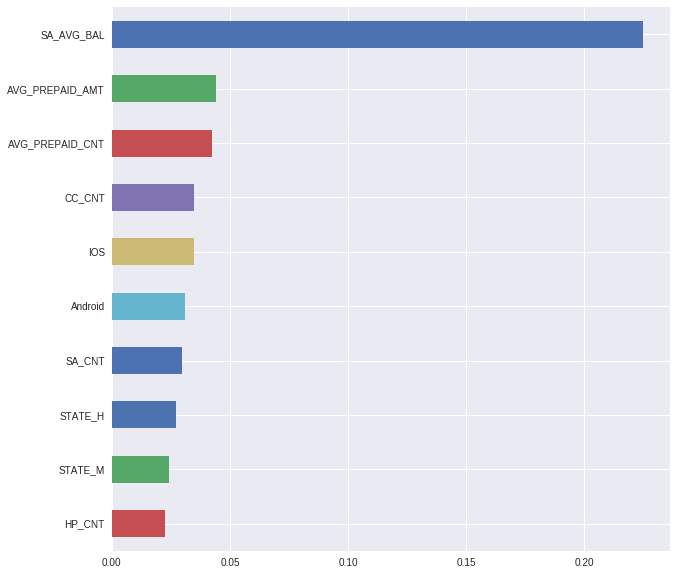

In [0]:
pd.Series(rf_clf.feature_importances_, index = X_train.columns).nlargest(10).plot(kind = 'barh', figsize = (10, 10)).invert_yaxis();

#### Performance metrics

In [0]:
print(metrics.confusion_matrix(y_test, rf_y_pred))

[[1359    2]
 [  58   38]]


In [0]:
print(metrics.classification_report(y_test, rf_y_pred))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1361
          1       0.95      0.40      0.56        96

avg / total       0.96      0.96      0.95      1457



In [0]:
metrics.roc_auc_score(y_test, rf_y_pred)

0.6971819128092089

In [0]:
rf_y_test = clf.predict(X_test)
rf_probability_test = clf.predict_proba(X_test)[:,1]

#### K-fold Cross-validation (where K = 5)

In [0]:
scoring = ['precision_macro', 'recall_macro', 'accuracy']
scores = cross_validate(clf, X, y, scoring=scoring,
                       cv = 5, return_train_score = False)

In [0]:
scores

{'fit_time': array([13.44686246, 13.68999958, 13.52411819, 13.22217441, 13.9096384 ]),
 'score_time': array([1.6826334 , 1.57147932, 1.38709903, 1.38797331, 1.18810463]),
 'test_accuracy': array([0.93687822, 0.93445436, 0.93102265, 0.93717817, 0.39581188]),
 'test_precision_macro': array([0.80191163, 0.55956221, 0.49470957, 0.9685783 , 0.53945525]),
 'test_recall_macro': array([0.50522226, 0.50378643, 0.49942069, 0.50271739, 0.64966165])}

#### Validation Set Evaluation

In [0]:
rf_y_val = clf.predict(X_val)
rf_probability = clf.predict_proba(X_val)[:,1]

In [0]:
rf_probability

array([0.025, 0.025, 0.025, ..., 0.457, 0.457, 0.119])

### XGBoost Classifier

#### Single Run

In [0]:
# fit model with training data
xgb_model = XGBClassifier(max_depth = 32, n_estimators = 1000)
xgb_model.fit(X_train, y_train)

# make predictions for test data
xgb_y_pred = xgb_model.predict(X_test)

# evaluate predictions
accuracy = metrics.accuracy_score(y_test, xgb_y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.47%


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:
xgb_y_test = xgb_model.predict(X_test)
xgb_probability_test = xgb_model.predict_proba(X_test)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


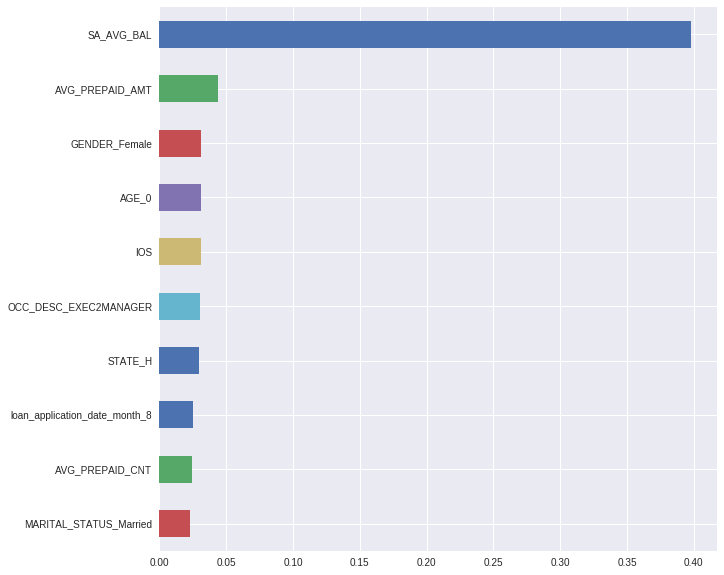

In [0]:
pd.Series(model.feature_importances_, index = X_train.columns).nlargest(10).plot(kind = 'barh', figsize = (10, 10)).invert_yaxis();

#### Performance metrics

In [0]:
print(metrics.confusion_matrix(y_test, xgb_y_pred))

[[1349   12]
 [  54   42]]


In [0]:
print(metrics.classification_report(y_test, xgb_y_pred))

             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1361
          1       0.78      0.44      0.56        96

avg / total       0.95      0.95      0.95      1457



In [0]:
metrics.roc_auc_score(y_test, xgb_y_pred)

0.7143414768552535

#### K-fold cross-validation (where K = 5)

In [0]:
# CV model
model = xgboost.XGBClassifier(max_depth = 32, n_estimators = 1000)
kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model, X, y, cv=kfold)

print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [0]:
xgb_y_val = model.predict(X_val)
xgb_probability = model.predict_proba(X_val)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### SVM Classifier

In [0]:
scoring = ['precision_macro', 'recall_macro', 'accuracy']
svm_clf = svm.SVC(kernel='rbf', C=10, random_state=0, probability=True)

print(X_train.shape, y_train.shape)

(13112, 47) (13112,)


In [0]:
svm_clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)

In [0]:
svm_y_pred = svm_clf.predict(X_test)

print(metrics.classification_report(y_test, svm_y_pred))


             precision    recall  f1-score   support

          0       0.93      1.00      0.97      1361
          1       0.00      0.00      0.00        96

avg / total       0.87      0.93      0.90      1457



In [0]:
svm_y_test = svm_clf.predict(X_test)
svm_probability_test = svm_clf.predict_proba(X_test)[:,1]

In [0]:
print(metrics.confusion_matrix(y_test, svm_y_pred))


[[1360    1]
 [  96    0]]


In [0]:
metrics.roc_auc_score(y_test, svm_y_pred)

0.4996326230712711

#### Single Run

In [0]:
# scores = cross_validate(clf, X, y, scoring=scoring,
#                         cv=5, return_train_score=False)
# sorted(scores.keys())

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


['fit_time',
 'score_time',
 'test_accuracy',
 'test_precision_macro',
 'test_recall_macro']

In [0]:
# print("precision: {}, \nrecall: {} \naccuracy: {}".format(scores['test_precision_macro'], scores['test_recall_macro'], scores['test_accuracy']))

precision: [0.46824579 0.46841744 0.46842828 0.46841744 0.5308903 ], 
recall: [0.4996337  0.49981685 0.5        0.5        0.56867761] 
accuracy: [0.93584906 0.93651338 0.93685655 0.93683488 0.21558531]


In [0]:
svm_predict = clf.predict(X_val)
svm_probability = clf.predict_proba(X_val)[:,1]

In [0]:
svm_probability.shape

(6231,)

## Final Result

In [0]:
table_val = {}
# table_val['BANK_ID'] = series_bank
table_val['XGB_DELQ_FLG'] = xgb_y_test
table_val['RF_DELQ_FLG'] = rf_y_test
table_val['XGB_PROBABILITY'] = xgb_probability_test
table_val['RF_PROBABILITY'] = rf_probability_test

table_val['SVM_DELQ_FLG'] = svm_y_test
table_val['SVM_PROBABILITY'] = svm_probability_test

df_ensemble = pd.DataFrame.from_dict(table_val)

df_ensemble.head()

,RF_DELQ_FLG,RF_PROBABILITY,SVM_DELQ_FLG,SVM_PROBABILITY,XGB_DELQ_FLG,XGB_PROBABILITY
0,0,0.060612,0,0.060612,0,0.000024
1,0,0.050712,0,0.050712,0,0.000048
2,0,0.068468,0,0.068468,0,0.000223
3,0,0.064961,0,0.064961,0,0.016678
4,0,0.066469,0,0.066469,0,0.005340


In [0]:
ensemble_probability_test = (xgb_probability_test + rf_probability_test)/2
ensemble_y_test = np.round(ensemble_probability_test)

In [0]:
print(metrics.classification_report(y_test, ensemble_y_test))
print(metrics.confusion_matrix(y_test, ensemble_y_test))
print("roc_auc_score: {}".format(metrics.roc_auc_score(y_test, ensemble_y_test)))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1361
          1       0.87      0.35      0.50        96

avg / total       0.95      0.95      0.94      1457

[[1356    5]
 [  62   34]]
roc_auc_score: 0.675246448689689


In [0]:
table = {}
table['BANK_ID'] = val_bank_id
table['XGB_DELQ_FLG'] = xgb_y_val
table['RF_DELQ_FLG'] = rf_y_val
table['XGB_PROBABILITY'] = xgb_probability
table['RF_PROBABILITY'] = rf_probability

table['SVM_DELQ_FLG'] = svm_predict
table['SVM_PROBABILITY'] = svm_probability

In [0]:
df_submit = pd.DataFrame.from_dict(table)

In [0]:
df_submit.head()

,BANK_ID,RF_DELQ_FLG,RF_PROBABILITY,SVM_DELQ_FLG,SVM_PROBABILITY,XGB_DELQ_FLG,XGB_PROBABILITY
0,10001,0,0.025,0,0.022196,0,0.001139
1,10001,0,0.025,0,0.022196,0,0.001139
2,10001,0,0.025,0,0.022196,0,0.001139
6,10028,0,0.023,0,0.051547,0,0.000844
7,10030,0,0.056,0,0.100861,0,0.000972


In [0]:
df_submit.to_csv('submission.csv')

In [0]:
from google.colab import files

files.download('submission.csv')